In [3]:
import numpy as np
import pyopencl as cl
import pyopencl.array

In [4]:
%matplotlib inline

In [5]:
import matplotlib.pyplot as plt

In [6]:
%load_ext pyopencl.ipython_ext

In [7]:
ctx = cl.create_some_context(interactive=True)

In [8]:
queue = cl.CommandQueue(ctx)

In [9]:
params = np.dtype([
    ('h_px',np.int32),
    ('w_px',np.int32),
    ('x_min',np.float32),
    ('x_max',np.float32),
    ('y_min',np.float32),
    ('y_max',np.float32),
])

In [10]:
params, params_c_decl = cl.tools.match_dtype_to_c_struct(ctx.devices[0], "params", params)
params = cl.tools.get_or_register_dtype("params", params)

In [11]:
%%cl_kernel -o "-cl-fast-relaxed-math"

#include <pyopencl-random123/threefry.cl>

typedef struct {
  int h_px;
  int w_px;
  float x_min;
  float x_max;
  float y_min;
  float y_max;
} params;

__kernel void uniform(
    __global int *result,
    //__local float2 *pos,
    __global params *my_params
)
{
    int h = (*my_params).h_px;
    int w = (*my_params).w_px;
    //float x_min = (*my_params).x_min;
    //float x_max = (*my_params).x_max;
    //float y_min = (*my_params).y_min;
    //float y_max = (*my_params).y_max;
    
    unsigned gid = get_global_id(0);
    unsigned lid = get_local_id(0);
    
    threefry4x32_key_t k = {{gid, 0xdecafbad, 0xfacebead, 0x12345678}};
    threefry4x32_ctr_t c = {{0, 0xf00dcafe, 0xdeadbeef, 0xbeeff00d}};
    
    union {
        threefry4x32_ctr_t c;
        int4 i;
    } u;
    u.c = threefry4x32(c, k);
    int x = u.i.x % w;
    int y = u.i.y % h;
    
    result[w * y + x]++;
}

/Users/amorg7/anaconda/lib/python3.6/site-packages/pyopencl-2017.2.2-py3.6-macosx-10.7-x86_64.egg/pyopencl/cffi_cl.py:1520: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


In [12]:
h_px = 400
w_px = 400
x_min = -1.
x_max = 1.
y_min = -1
y_max = 1

p = (h_px,w_px,x_min,x_max,y_min,y_max)
my_params_host = np.array([p],dtype=params)
my_params = cl.array.to_device(queue,my_params_host)
n = w_px*h_px
result = cl.array.empty(queue, n, dtype=np.int32)

In [13]:
uniform(queue, (n,), None, result.data,my_params.data)

In [14]:
result_host = result.get()

In [15]:
img = result_host.reshape([h_px,w_px])

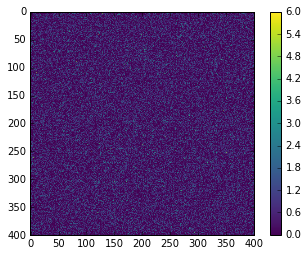

In [16]:
plt.imshow(img,cmap='viridis')
plt.colorbar()

In [17]:
dev = ctx.devices[0]

In [18]:
dev.max_work_group_size

512

In [19]:
%env PYOPENCL_COMPILER_OUTPUT=1

env: PYOPENCL_COMPILER_OUTPUT=1


In [61]:
%%cl_kernel -o "-cl-fast-relaxed-math"

#include <pyopencl-random123/threefry.cl>
#include <pyopencl-complex.h>

#define grp_size 320

typedef struct {
  int h_px;
  int w_px;
  float x_min;
  float x_max;
  float y_min;
  float y_max;
} params;

float uprob(float x, float y);
float uprob2(float x, float y);

float uprob(float x, float y){
    cfloat_t z = cfloat_new(x,y);
    cfloat_t c = z;
    for(int i=0;i<100;i++){
        z = cfloat_add(cfloat_mul(z,z),c);
        if(cfloat_abs(z)>4.) {
            return 1.;
        }
    }
    return 0.;
}


float uprob2(float x, float y){
    return x*y;
}

__kernel void uniform(
    __global float *result,
    __global params *my_params
)
{
    uint h = (uint)(*my_params).h_px;
    uint w = (uint)(*my_params).w_px;
    float x_min = (*my_params).x_min;
    float x_max = (*my_params).x_max;
    float y_min = (*my_params).y_min;
    float y_max = (*my_params).y_max;
    int max_iter = 10;
    float step_size = .1;
    float shrink = .9;
    
    uint gid = get_global_id(0);
    uint lid = get_local_id(0);
 
    __local float2 pos[grp_size];
    
    threefry4x32_key_t k = {{gid, 0xdecafbad, 0xfacebead, 0x12345678}};
    threefry4x32_ctr_t c = {{0, 0xf00dcafe, 0xdeadbeef, 0xbeeff00d}};
    
    union {
        threefry4x32_ctr_t c;
        uint4 i;
    } u;
    u.c = threefry4x32(c, k);
    int x_i = u.i.x % w;
    int y_i = u.i.y % h;

    float x = (x_max - x_min ) * (x_i / (float) w ) + x_min;
    float y = (y_max - y_min ) * (y_i / (float) h ) + y_min;
    
    float step_x;
    float step_y;
    float p;
    
    // share position with work group
    pos[lid].x = x;
    pos[lid].y = y;
    barrier(CLK_LOCAL_MEM_FENCE);
    evol:
    for(int j=0; j<max_iter;j++) {
        step_size = step_size * shrink;
        c.v[0]++;
        u.c = threefry4x32(c, k);
        
        
        // pick a candidate to (possibly) jump to
        int lid2 = u.i.x % grp_size;
        barrier(CLK_LOCAL_MEM_FENCE);
        float x2 = pos[lid2].x;
        float y2 = pos[lid2].y;
        
        // Selection
        p = float(u.i.y % 10000) / 10000.;
        if((x == 0.)&&(y==0.)) {
            x = x2;
            y = y2;
        }
        else if(uprob(x2,y2) / uprob(x,y) > p){
            x = x2;
            y = y2;
        }
        
        // Mutation
        step_x = step_size * ((u.i.z % 10000) / 10000. - .5);
        step_y = step_size * ((u.i.w % 10000) / 10000. - .5);
        
        x = x + step_x;
        y = y + step_y;
        
        // Share new position with work group
        pos[lid].x = x;
        pos[lid].y = y;
        barrier(CLK_LOCAL_MEM_FENCE);
    }
    
    x_i = (pos[lid].x - x_min) * w / (x_max - x_min);
    y_i = (pos[lid].y - y_min) * h / (y_max - y_min);

    result[w * y_i + x_i]++;

}

In [62]:
h_px = 300
w_px = 300
x_min = -1.
x_max = 1.
y_min = -1
y_max = 1

p = (h_px,w_px,x_min,x_max,y_min,y_max)
my_params_host = np.array([p],dtype=params)
my_params = cl.array.to_device(queue,my_params_host)
n = h_px*w_px
result = cl.array.empty(queue, n, dtype=np.float32)

In [63]:
uniform(queue, (1000000,), None, result.data,my_params.data)

In [64]:
result_host = result.get()

In [65]:
from seaborn import distplot

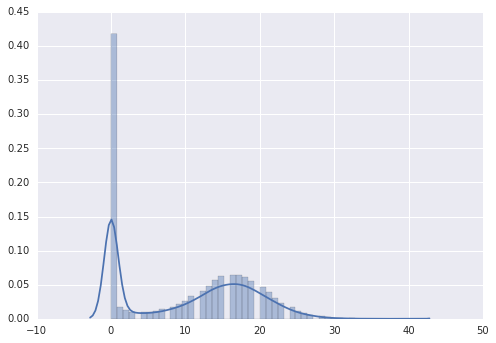

In [66]:
distplot(result_host)

In [67]:
result_host

array([ 17.,  12.,  14., ...,   7.,   8.,   8.], dtype=float32)

In [68]:
result_host.min()

0.0

In [69]:
result_host.max()

40.0

In [70]:
result_host.mean()

10.196366

In [71]:
img = result_host.reshape([h_px,w_px])

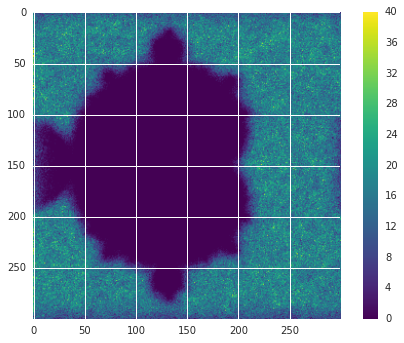

In [72]:
plt.imshow(img,cmap='viridis')
plt.colorbar()